In [1]:
import pandas as pd
import json
import glob
import re
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from nltk.corpus import stopwords
from collections import Counter

# import nltk
# nltk.download('stopwords')

In [2]:
# Import data extracted from PubMed
mesh_articles = pd.read_json('JSON Data/biomed_pubmed_data.json')[['Pubmed ID', 'Title', 'Abstract', 'Date']].dropna()
med_dev_articles = pd.read_json('JSON Data\device_pubmed_data.json')[['Pubmed ID', 'Title', 'Abstract', 'Date']].dropna()

# Combine datasets and remove duplicates
articles = med_dev_articles.append(mesh_articles).drop_duplicates()

# TF-IDF

In [3]:
def clean_docs(doc):
    '''Accepts an individual string (not a list of string). Removes stopwords and does other cleaning'''
    stops = stopwords.words('english') + ['biomedical', 'engineering', 'medical', 'devices', 'device', 'used', 'using', 'use']
    
    doc = doc.lower()
    doc = doc.translate(str.maketrans("", "", r'!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~')) # remove punctuation
    doc = doc.translate(str.maketrans("-", " "))  # replace dashes with spaces
    doc = re.sub(r'([ ]{2,})', ' ', doc)  # remove extra white spaces
    doc = [word for word in doc.split() if word not in stops] # remove stopwords
    doc = " ".join(doc)
    doc = re.sub(r'[\d]', '', doc) # remove digits
    doc = re.sub(r'([ ]{2,})', ' ', doc)
    doc = re.sub(r'[\s]$', '', doc) # remove whitespace at end of string
    return doc

In [4]:
# Cleaning method seems to break words that are hyphenated due to a line break. ex: "units integral requirements delive ry direct patient"
df = mesh_articles
abst = [clean_docs(i) for i in list(df['Abstract'])]

In [5]:
# Documentation for vectorizer: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
vec_max_feat = 200
vectorizer = TfidfVectorizer(   max_features=vec_max_feat,
                                max_df=0.8,  # max document frequency. Words in more the x% will be ignored
                                min_df=5, # min document frequency. Will ignore words that occur less than x times in the corpus
                                ngram_range = (1,3),  # allows x-grams to y-grams to be captured. E.g. unigrams to trigrams
                                stop_words = "english"  # will catch stopwords specific to sklearn
                                )

In [6]:
# Vectorize and isolate keywords from documents
vectors = vectorizer.fit_transform(abst)
feature_names = vectorizer.get_feature_names()

dense = vectors.todense()
denselist = dense.tolist()

'''
Denselist is a collection of all documents. But each document in the denselist is not a representation of the words in the document. Instead, it is an index of the feature_names with each word represented with its corresponding tf-idf score. In other words, it is a list of x key words and the tf-idf score for each word in the feature_names for a given document. If the keyword does not appear in the document, it has a score of 0. If, however, it does, that keyword has a tf-idf score, which means it is found within the document.
'''

all_keywords = []
for description in denselist:  # Find features (keywords) that have been found in each document
    keywords = []
    for i, word in enumerate(description):
        if word > 0:
            keywords.append(feature_names[i])
    all_keywords.append(keywords)

Example: The 9th value in this denselist document is the tf-idf value for the 9th word in the feature_names.

In [7]:
denselist[0][0:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.26193792048282244]

In [8]:
feature_names[0:10]

['activity',
 'addition',
 'analysis',
 'application',
 'applications',
 'applied',
 'approach',
 'area',
 'areas',
 'article']

In [9]:
# K-Means Clustering

nk = 6 # Number of desired clusters
model = KMeans(n_clusters=nk, init="k-means++", max_iter=200, n_init=5)
model.fit(vectors)

KMeans(max_iter=200, n_clusters=6, n_init=5)

In [10]:
# Write file with top 10 words from each cluster
'''
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

date = datetime.datetime.now().strftime('%Y_%m_%d')
with open (f"TF-IDF Plots and Clusters/{date} cluster_results.txt", "w", encoding="utf-8") as f:
    f.write(f"Max vectorization features:{vec_max_feat}\nClusters:{nk}\n\n")
    for i in range(nk):
        f.write(f"Cluster {i + 1}")
        f.write("\n")
        for ind in order_centroids[i, :10]:
            f.write (" %s" % terms[ind],)
            f.write("\n")
        f.write("\n")
        f.write("\n")
'''

'\norder_centroids = model.cluster_centers_.argsort()[:, ::-1]\nterms = vectorizer.get_feature_names()\n\ndate = datetime.datetime.now().strftime(\'%Y_%m_%d\')\nwith open (f"TF-IDF Plots and Clusters/{date} cluster_results.txt", "w", encoding="utf-8") as f:\n    f.write(f"Max vectorization features:{vec_max_feat}\nClusters:{nk}\n\n")\n    for i in range(nk):\n        f.write(f"Cluster {i + 1}")\n        f.write("\n")\n        for ind in order_centroids[i, :10]:\n            f.write (" %s" % terms[ind],)\n            f.write("\n")\n        f.write("\n")\n        f.write("\n")\n'

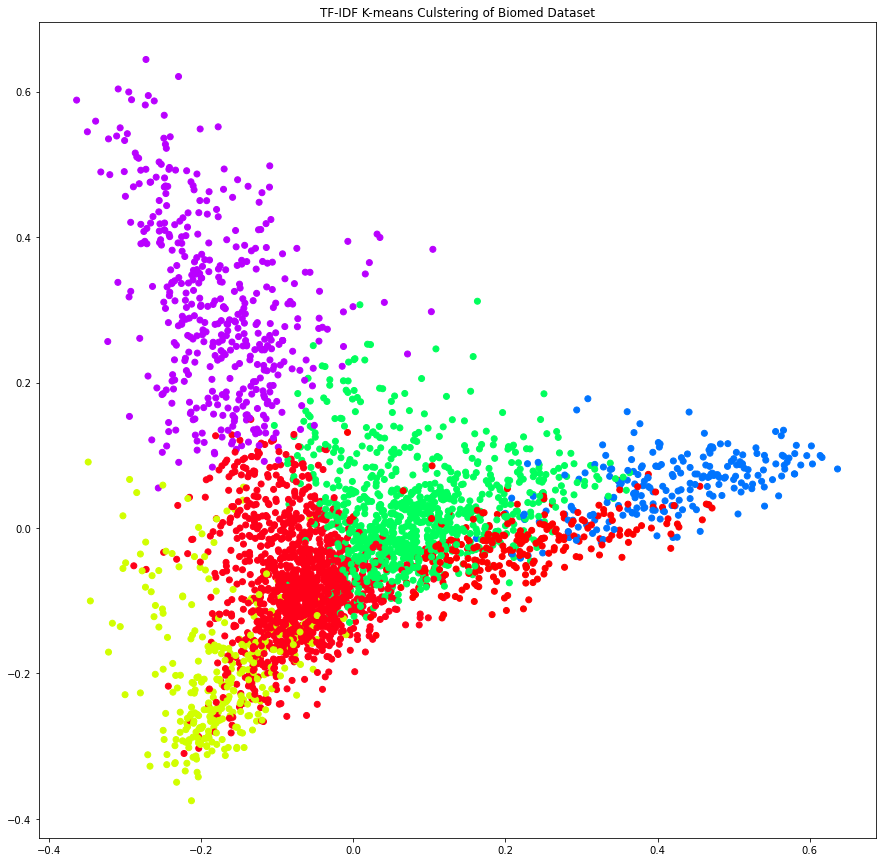

In [11]:
# Data Visualization
# https://stackoverflow.com/questions/27494202/how-do-i-visualize-data-points-of-tf-idf-vectors-for-kmeans-clustering

kmeans_indices = model.fit_predict(vectors)

pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(vectors.toarray())

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]

fig, ax = plt.subplots(figsize=(15,15))

# https://stackoverflow.com/questions/65927253/linearsegmentedcolormap-to-list
cmap = plt.cm.get_cmap('hsv', nk)
cmap_list = [mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)]

ax.scatter(x_axis, y_axis, c=[cmap_list[d] for d in kmeans_indices])
ax.set_title(f'TF-IDF K-means Culstering of Biomed Dataset')

# for i, date in enumerate(df['Date'].apply(lambda x : eval(x).year)):
#     ax.annotate(date, (x_axis[i], y_axis[i]))

#plt.savefig(f'TF-IDF Plots and Clusters/{date} plot.png')
plt.show()

In [12]:
# TODO
# Graph cluster prevalence by year

In [13]:
full_counter_dict = {}

for i, date in enumerate(df['Date'].apply(lambda x : eval(x).year)):
    if date not in full_counter_dict.keys():
        full_counter_dict[date] = Counter()
        full_counter_dict[date].update([kmeans_indices[i]])
    if date in full_counter_dict.keys():
        full_counter_dict[date].update([kmeans_indices[i]])
    else:
        print(f'error:{i}')

In [20]:
kratio_df = pd.DataFrame(full_counter_dict)
kratio_df = kratio_df.fillna(0)
kratio_df = kratio_df.append(kratio_df.apply(sum, axis=0).reindex_like(kratio_df.columns.to_series()).rename('Sums'), ignore_index=False)

In [21]:
kratio_df

,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,...,1975,1972,1970,1969,1968,1964,1962,1960,1957,1955
3,5.0,0.0,0.0,14.0,29.0,26.0,45.0,17.0,11.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.0,4.0,38.0,105.0,89.0,79.0,100.0,70.0,25.0,...,12.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0
0,0.0,0.0,0.0,1.0,10.0,8.0,8.0,5.0,3.0,7.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0
5,0.0,0.0,0.0,5.0,77.0,36.0,49.0,172.0,172.0,33.0,...,5.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,4.0,48.0,21.0,28.0,117.0,82.0,36.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,18.0,8.0,6.0,43.0,28.0,7.0,...,0.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
Sums,5.0,2.0,4.0,63.0,287.0,188.0,215.0,454.0,366.0,109.0,...,22.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0
